In [1]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from kymatio import Scattering2D
import os

import torch
import numpy as np
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data import Subset
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [4]:
logdir = './training_logs' #directory for training logs
savedir = './checkpoints' #directory to save checkpoints
dataset_name = 'FashionMNIST'
workers = 1 #number of data loading workers
batch_size = 256 #mini-batch size (default: 256), this is the total batch size of all GPUs on the current node when using Data Parallel or Distributed Data Parallel

# Scattering parameters
max_order = 1
L = 6 #number of orientations for scattering
J = 3 #maximum scale for the scattering transform
backend = 'torch' #scattering backend

In [5]:
def draw_scat_coef(img, scattering):
    scattering_coefficients = scattering(img)
    print("coeffs shape: ", scattering_coefficients.shape)
    # Invert colors
    scattering_coefficients = -scattering_coefficients
    
    scattering_coefficients = scattering_coefficients[1:, :, :]
    norm = mpl.colors.Normalize(scattering_coefficients.min(), scattering_coefficients.max(), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap="gray")
    nb_coeffs, window_rows, window_columns = scattering_coefficients.shape
    
    fig,ax = plt.subplots()

    plt.imshow(1-img,cmap='gray',interpolation='nearest', aspect='auto')
    ax.axis('off')
    offset = 0.1
    for row in range(window_rows):
        for column in range(window_columns):
            ax=fig.add_subplot(window_rows, window_columns, 1 + column + row * window_rows, projection='polar')
            ax.set_ylim(0, 1)
            ax.axis('off')
            ax.set_yticklabels([])  # turn off radial tick labels (yticks)
            ax.set_xticklabels([])  # turn off degrees
            # ax.set_theta_zero_location('N')  # 0° to North
            coefficients = scattering_coefficients[:, row, column]
            for j in range(J):
                for l in range(L):
                    coeff = coefficients[l + (J - 1 - j) * L]
                    color = mpl.colors.to_hex(mapper.to_rgba(coeff))
                    ax.bar(x=(4.5+l) *  np.pi / L,
                           height=2*(2**(j-1) / 2**J),
                           width=2 * np.pi / L,
                           bottom=offset + (2**j / 2**J) ,
                           color=color)
                    ax.bar(x=(4.5+l+L) * np.pi / L,
                           height=2*(2**(j-1) / 2**J),
                           width=2 * np.pi / L,
                           bottom=offset + (2**j / 2**J) ,
                           color=color)

In [6]:
dataset_dir = os.path.join(os.path.expanduser("~"), 'Datasets', 'MNIST')
valid_ratio = 0.2  # Going to use 80%/20% split for train/valid
# normalize = transforms.Normalize(mean=[0.485], std=[0.229])
# Load the dataset for the training/validation sets
train_valid_dataset = datasets.MNIST(root=dataset_dir,
                                        train=True,
                                        transform= transforms.Compose([
#                                                     transforms.RandomResizedCrop(224),
                                                    transforms.RandomHorizontalFlip(),
                                                    transforms.ToTensor(),
#                                                     normalize
                                                ]), 
                                        download=True)
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])

In [7]:
train_dataset = Subset(train_dataset, np.arange(512))
valid_dataset = Subset(valid_dataset, np.arange(512))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False,
                                           num_workers=workers, pin_memory=True)
val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,
                                           num_workers=workers, pin_memory=True)

/home/eliem/anaconda3/envs/pfe_env/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


torch.Size([256, 1, 28, 28])


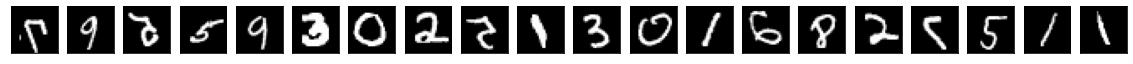

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

nsamples=20
# classes_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal','Shirt', 'Sneaker', 'Bag', 'Ankle boot']
classes_names = ['', '', '', '', '', '','', '', '', '']
imgs, labels = next(iter(train_loader))

fig=plt.figure(figsize=(20,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs[i, 0, :, :], vmin=0, vmax=1.0, cmap=cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
print(imgs.size())

In [9]:
scattering = Scattering2D(J=J, shape=imgs[0,0].shape, L=L, max_order=max_order,
                              backend=backend)

coeffs shape:  torch.Size([19, 3, 3])
coeffs shape:  torch.Size([19, 3, 3])


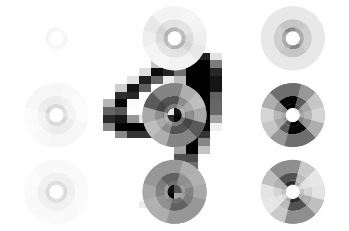

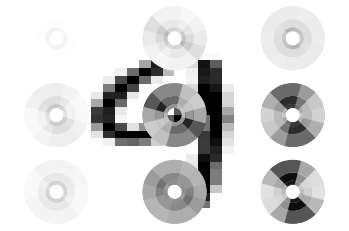

In [11]:
draw_scat_coef(imgs[1][0], scattering)
draw_scat_coef(imgs[4][0], scattering)

coeffs shape:  torch.Size([19, 3, 3])
coeffs shape:  torch.Size([19, 3, 3])


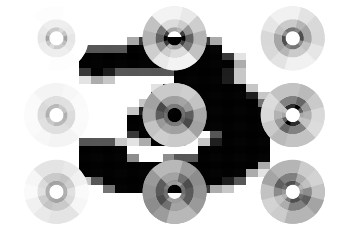

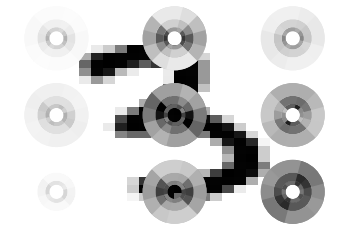

In [12]:
draw_scat_coef(imgs[5][0], scattering)
draw_scat_coef(imgs[10][0], scattering)

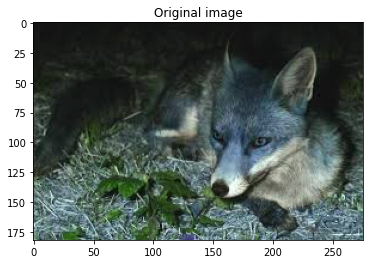

In [78]:
import cv2
src_img = cv2.imread('imagenet_test.png', cv2.IMREAD_COLOR)
# src_img = cv2.resize(src_img, (28,28))
src_img = np.array(src_img)
src_img = src_img.astype(np.float32) / 255.

plt.imshow(src_img)
plt.title("Original image")
src_img = np.moveaxis(src_img, -1, 0)

In [79]:
# src_img = torch.from_numpy(src_img)
channels, h, w  = src_img.shape

In [80]:
scattering = Scattering2D(J=J, shape=(h, w), L=L, max_order=max_order)

In [81]:
type(src_img)

numpy.ndarray

In [86]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    scattering = scattering.cuda()
src_img_tensor = torch.from_numpy(src_img).to(device)
scattering_coefficients = scattering(src_img_tensor.contiguous())

In [85]:
draw_scat_coef(src_img_tensor.contiguous(), scattering)

coeffs shape:  torch.Size([3, 19, 22, 34])


ValueError: too many values to unpack (expected 3)